# Ford GoBike System Data Exploration
## by Kevin Wang

## Investigation Overview

In this investigation, I looked at the factors that will influence the bike usage like trips number and trips duration for this bike sharing system. The main features I took into the consideration are the time factors (hour of day, day of week and month of year), user types (memeber or casual user) and user genders (Male, Female and Other).

## Dataset Overview

The dataset includes 1,732,358 trip records from January to Noverber in 2018. And the main attributes include the duration in seconds, the start/end date and time, the start/end station ID and station name, the start/end latitude and longitude, the user type and user gender.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Create an empty dataframe
trips = pd.DataFrame()
# Load all data by month in loop
for i in range(11):
    df = pd.read_csv('dataset/2018{:0>2d}-fordgobike-tripdata.csv'.format(i+1))
    trips = trips.append(df, ignore_index = True)

In [3]:
# Copy the original data
trips_clean = trips.copy()

# Convert the start_time and end_time to datetime type
trips_clean['start_time'] = pd.to_datetime(trips_clean['start_time'])
trips_clean['end_time'] = pd.to_datetime(trips_clean['end_time'])

# Conver the user_type to categorical data type
trips_clean['user_type'] = trips_clean['user_type'].astype('category')
# Convert the member_gender to categorical data type
trips_clean['member_gender'] = trips_clean['member_gender'].astype('category')

# Convert the id columns (bike_id, start_station_id, end_station_id) to string
trips_clean['bike_id'] = trips_clean['bike_id'].apply(lambda x: '{:.0f}'.format(x) if pd.isnull(x)==False else x)
trips_clean['start_station_id'] = trips_clean['start_station_id'].apply(lambda x: '{:.0f}'.format(x) if pd.isnull(x)==False else x)
trips_clean['end_station_id'] = trips_clean['end_station_id'].apply(lambda x: '{:.0f}'.format(x) if pd.isnull(x)==False else x)

# Define function to get the hour of day
def get_hour(dt):
    return dt.time().strftime('%H')

# Define function to get the day of week
def get_weekday(dt):
    return dt.date().strftime('%a')

# Define function to get the month of year
def get_month(dt):
    return dt.date().strftime('%b')

# Feature engineering: Add new column to get the part of day
trips_clean['start_hour'] = trips_clean['start_time'].apply(get_hour)
trips_clean['end_hour'] = trips_clean['end_time'].apply(get_hour)

# Feature engineering: Add new column to calculate the day of week
trips_clean['start_day_of_week'] = trips_clean['start_time'].apply(get_weekday)
trips_clean['end_day_of_week'] = trips_clean['end_time'].apply(get_weekday)

# Feature engineering: Add new column to calculate the month of year
trips_clean['start_month'] = trips_clean['start_time'].apply(get_month)
trips_clean['end_month'] = trips_clean['end_time'].apply(get_month)

# Conver the start_hour and end_part_of_day to categorical data type
trips_clean['start_hour'] = trips_clean['start_hour'].astype('category')
trips_clean['end_hour'] = trips_clean['end_hour'].astype('category')
# Convert the start_day_of_week and end_day_of_week to categorical data type
trips_clean['start_day_of_week'] = trips_clean['start_day_of_week'].astype('category')
trips_clean['end_day_of_week'] = trips_clean['end_day_of_week'].astype('category')

# Conver the start_part_of_day and end_part_of_day to ordinal data type
# Convert the start_day_of_week and end_day_of_week to ordinal data type
ordinal_var_dict = {'hour': ['{:0>2d}'.format(v) for v in np.arange(0,24)],
                    'day_of_week': ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                    'month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    trips_clean['start_'+var] = trips_clean['start_'+var].astype(ordered_var)
    trips_clean['end_'+var] = trips_clean['end_'+var].astype(ordered_var)

In [4]:
# Re-calculate the duration
trips_clean['duration_sec'] = trips_clean.apply(lambda r: (r.end_time-r.start_time).seconds, axis=1)

## Distribution of Trip Duration

The duration in the dataset take on a very large range of values, from 61s to 86366s. The trip duration is plotted on a logarithmic scale, and the it follows a normal distribution. 

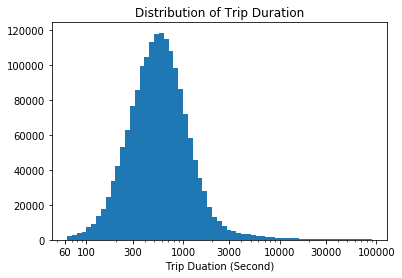

In [5]:
# Define the bins with log transformation
dur_log_bins=10**np.arange(1.8, np.log10(trips_clean['duration_sec'].max())+0.05, 0.05)
plt.hist(data=trips_clean, x='duration_sec', bins=dur_log_bins)
plt.xscale('log')
# Set the x ticks and ticks' labels
dur_log_ticks = [60, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duation (Second)')
plt.xticks(dur_log_ticks, dur_log_ticks)
plt.show()

## Number of Trips in terms of Time of Day, Day of Week and Month

Considering all time variables, I create the heatmap to show the bike uses from Jan-Nov in 2018. The color are darker in the weekdays around 8am and 5pm from May to Oct. Also, on the weekends people often use bike between 10am to 5pm.

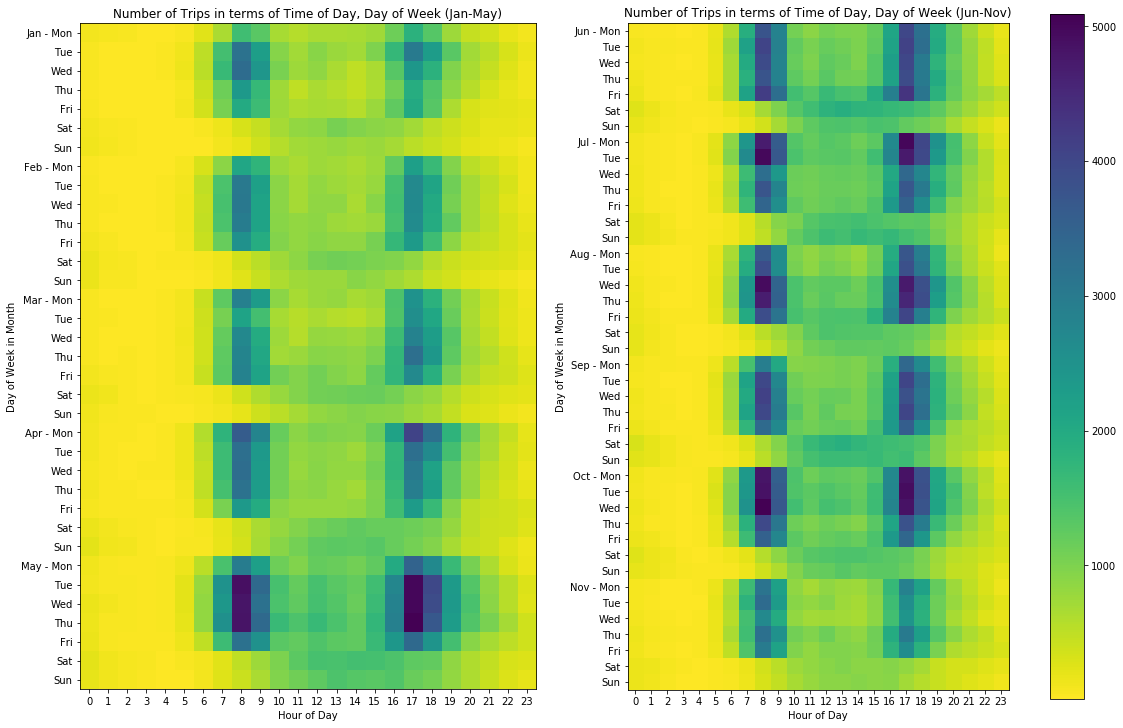

In [6]:
month_week_hour = trips_clean.pivot_table(index=['start_month','start_day_of_week'], columns=['start_hour'], aggfunc='count')

plt.figure(figsize=[18, 30])
ax = plt.subplot(1, 2, 1)
im = plt.imshow(month_week_hour['bike_id'].iloc[0:35], cmap='viridis_r')
ax.set_xticks(np.arange(0,24))
ax.set_yticks(np.arange(0,35))
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week in Month')
yticklabels = []
for i in range(0,5):
    for j in range(0,7):
        if j==0:
            yticklabels.append(ordinal_var_dict['month'][i]+' - '+ordinal_var_dict['day_of_week'][j])
        else:
            yticklabels.append(ordinal_var_dict['day_of_week'][j])
ax.set_yticklabels(yticklabels)
ax.set_title('Number of Trips in terms of Time of Day, Day of Week (Jan-May)')

ax = plt.subplot(1, 2, 2)
im = plt.imshow(month_week_hour['bike_id'].iloc[35:], cmap='viridis_r')
ax.set_xticks(np.arange(0,24))
ax.set_yticks(np.arange(0,42))
ax.set_xlabel('Hour of Day')
yticklabels = []
for i in range(5,11):
    for j in range(0,7):
        if j==0:
            yticklabels.append(ordinal_var_dict['month'][i]+' - '+ordinal_var_dict['day_of_week'][j])
        else:
            yticklabels.append(ordinal_var_dict['day_of_week'][j])
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Day of Week in Month')
ax.set_title('Number of Trips in terms of Time of Day, Day of Week (Jun-Nov)')
plt.colorbar(im, fraction=0.075, pad=0.09)

plt.show()

## Number of Trips in terms of Time Variables and User Type

For system member(subscriber), they took most of trips on 8am-9am and 5pm-6pm. But for casual user(customer), the number of trips gradually increase from 9am to the 5pm and then drop gradually from 6pm.

In terms of day of week, the number of trip for the member(subscriber) are most concentrated on the weekdays. But for casual users(customer), they took more trips on the weekends compared with the weekdays.

In terms of month of the year, the bike riding is move active from May to Oct for both the member and casual user. The most trips are taken on Oct for the member. While for the causal user, the most trips are taken on July.

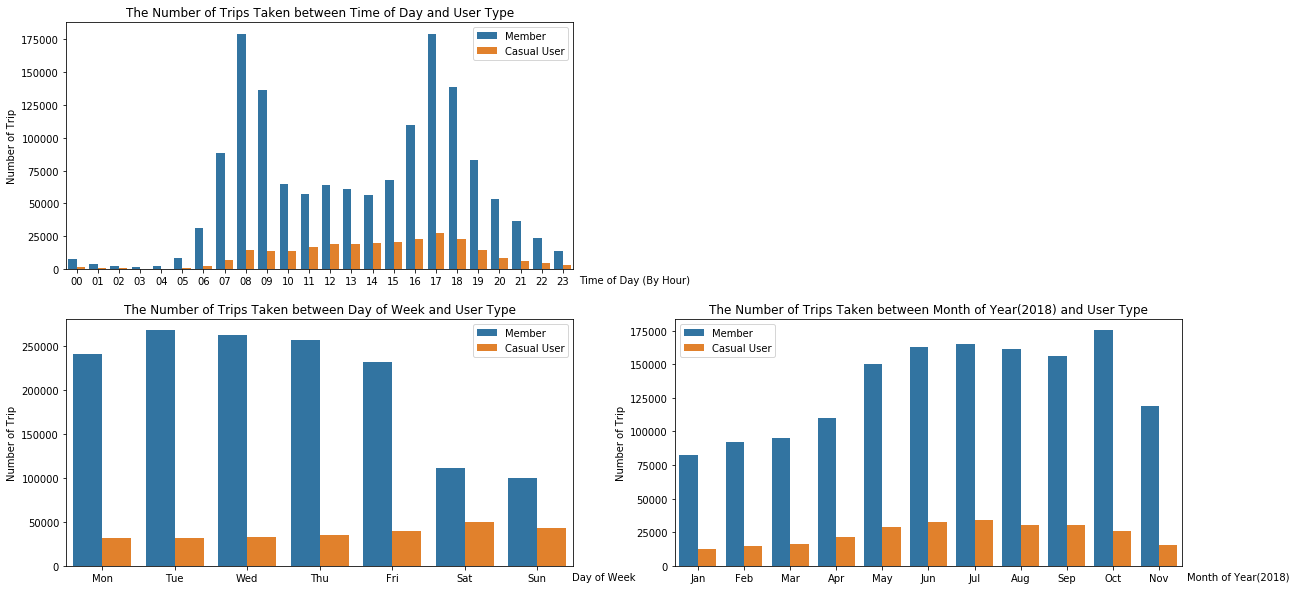

In [7]:
# Set figure size
plt.figure(figsize=[20,10])

ax = plt.subplot(2,2,1)
# Generate the first plot with x=start_hour and group by user_type
sb.countplot(data=trips_clean, x='start_hour', hue='user_type', hue_order=('Subscriber','Customer'))
# Set subplot title and x, y labels
ax.set_title('The Number of Trips Taken between Time of Day and User Type')
ax.set_xlabel('Time of Day (By Hour)')
# Set x label location
ax.xaxis.set_label_coords(1.12, -0.025)
ax.set_ylabel('Number of Trip')
# Set the legend and rename the labels
ax.legend(title='', labels=('Member','Casual User'))

ax = plt.subplot(2,2,3)
# Generate the first plot with x=start_day_of_week and group by user_type
sb.countplot(data=trips_clean, x='start_day_of_week', hue='user_type', hue_order=('Subscriber','Customer'))
ax.set_title('The Number of Trips Taken between Day of Week and User Type')
ax.set_xlabel('Day of Week')
# Set x label location
ax.xaxis.set_label_coords(1.06, -0.025)
ax.set_ylabel('Number of Trip')
ax.legend(title='', labels=('Member','Casual User'))

ax = plt.subplot(2,2,4)
# Generate the first plot with x=start_month and group by user_type
sb.countplot(data=trips_clean, x='start_month', hue='user_type', hue_order=('Subscriber','Customer'))
ax.set_title('The Number of Trips Taken between Month of Year(2018) and User Type')
ax.set_xlabel('Month of Year(2018)')
# Set x label location
ax.xaxis.set_label_coords(1.11, -0.025)
ax.set_ylabel('Number of Trip')
ax.legend(title='', labels=('Member','Casual User'))

plt.show()

## Number of Trips in terms of Day of Week and User Type

The casual user have the greater number of trips on weekend in almost every month except the May, August and Noverber but the differences of trip numbers in these exception months are quit small.  
And for the registered member, the number of trips on weekdays is greater than that of weekends.

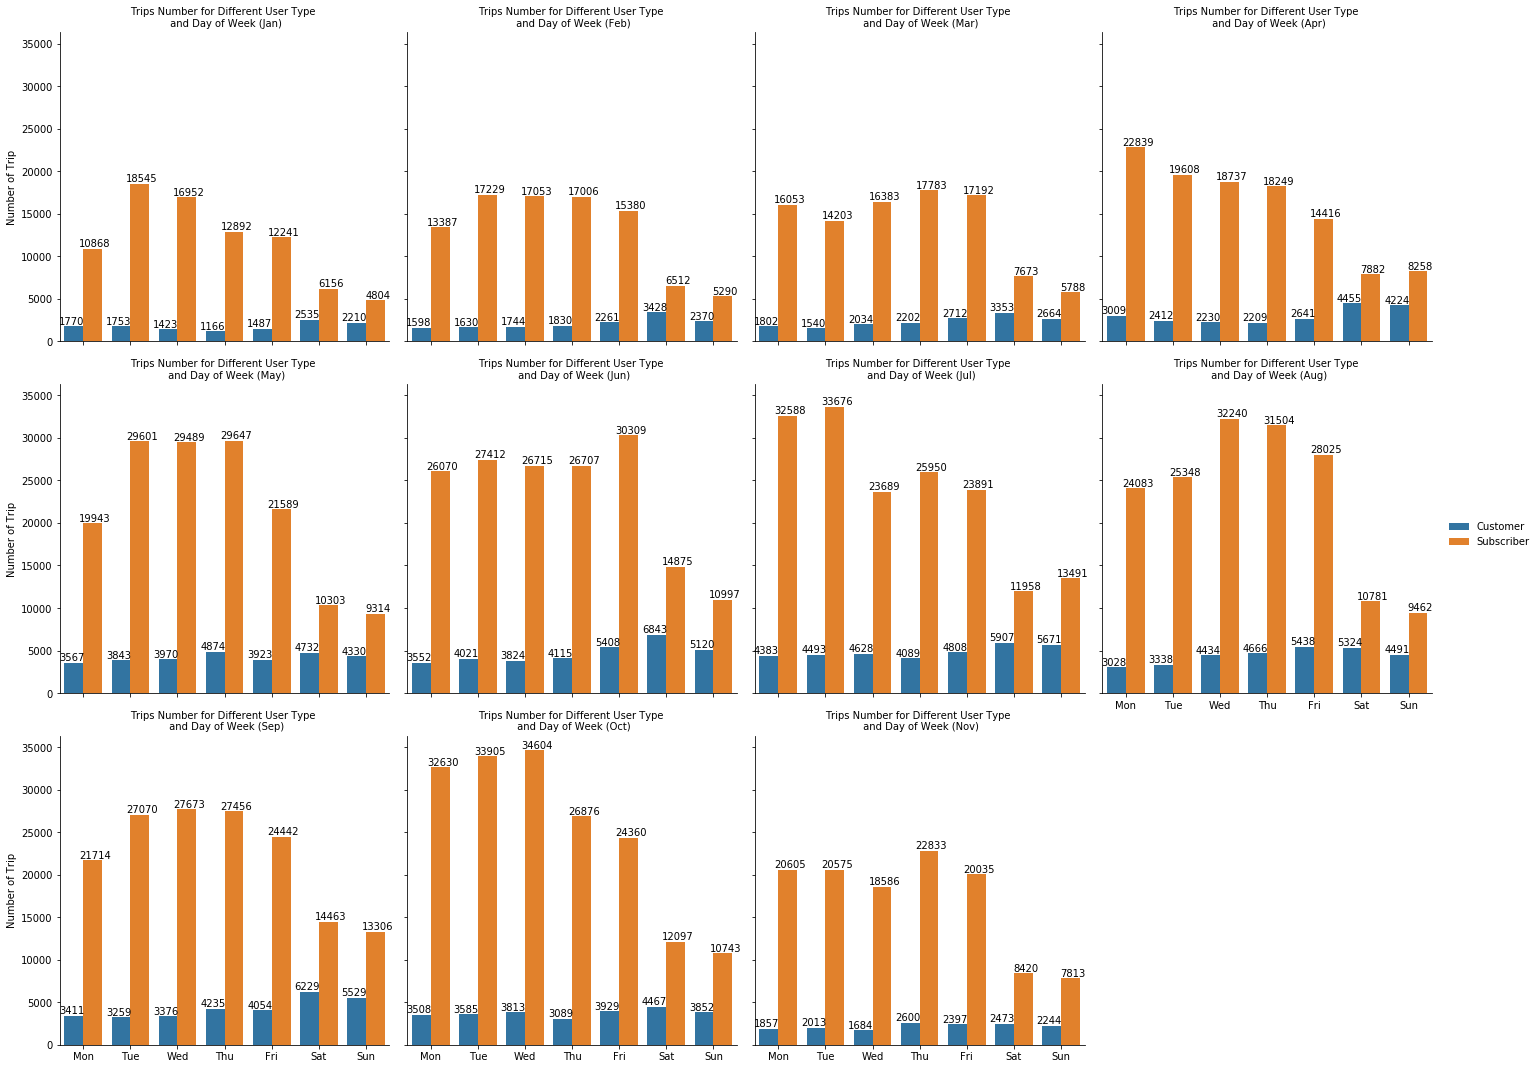

In [8]:
# Get the pivot table which is group by start_month, start_day_of_week and user_type
month_week_usertype = trips_clean.pivot_table(index='start_month', columns=['start_day_of_week','user_type'], aggfunc='count')

# I tired to use the FacetGrid with the sb.countplot as the function to be passed in the map, but I cannot get the right result.
# So I after searching I got another solution by using he catplot function as below
g = sb.catplot(data=trips_clean, x='start_day_of_week',col='start_month', hue='user_type', kind='count', col_wrap=4)
g.set_titles('Trips Number for Different User Type \n and Day of Week ({col_name})')
g.set_xlabels('')
g.set_ylabels('Number of Trip')
g._legend.set_title('')
# Show number of trip on the top of each bar
# Loop month
for i in range(len(ordinal_var_dict['month'])):
    # Loop day of week
    for j in range(len(ordinal_var_dict['day_of_week'])):
        # Get trip number of Customer from the pivot table
        val_cust = month_week_usertype['bike_id'].iloc[i][ordinal_var_dict['day_of_week'][j]]['Customer']
        # Get trip number of Subscriber from the pivot table
        val_subs = month_week_usertype['bike_id'].iloc[i][ordinal_var_dict['day_of_week'][j]]['Subscriber']
        # Show the annotation on top of Customer bars
        g.axes[i].text(j-0.25, val_cust, val_cust, ha="center", va="bottom", color="black")
        # Show the annotation on top of Subscriber bars
        g.axes[i].text(j+0.25, val_subs, val_subs, ha="center", va="bottom", color="black")    
plt.show()

## The Duration in terms of Day of Week and User Type

There is the clear trends that the duration of trips on weekend is longer than that on weekdays from Jan to Nov no matter for the member or casual user.  
And the duration of casual users is longer than that of the members for each of of days.

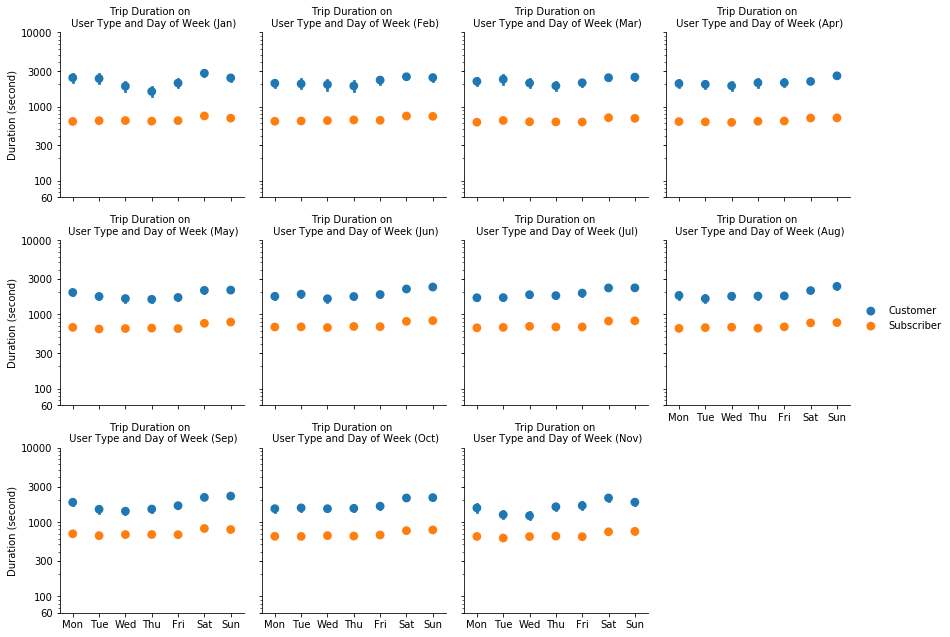

In [9]:
dur_log_ticks_lim = [60, 100, 300, 1000, 3000, 10000]
# Create FacetGrid
g = sb.FacetGrid(data=trips_clean, col='start_month', col_wrap=4)
# Pass the point plot as the input function
g.map(sb.pointplot, 'start_day_of_week', 'duration_sec', 'user_type', order=ordinal_var_dict['day_of_week'], 
      hue_order=['Customer','Subscriber'], linestyles = '', palette=sb.color_palette())
# Set y-axis transformation
g.set(yscale='log')
# Set ylim
g.set(ylim = np.array([60, 10000]))
# Set ticks and labels
g.set_titles('Trip Duration on \n User Type and Day of Week ({col_name})')
g.set(yticks = dur_log_ticks_lim)
g.set_yticklabels(dur_log_ticks_lim)
g.set_ylabels('Duration (second)')
g.set_xlabels('')
g.add_legend()
plt.show()

## The Duration for Different User Gender

An interesting thing I found is that the trip duration of female user is longer than that of male user in each day of week from Jan to Nov 2018.

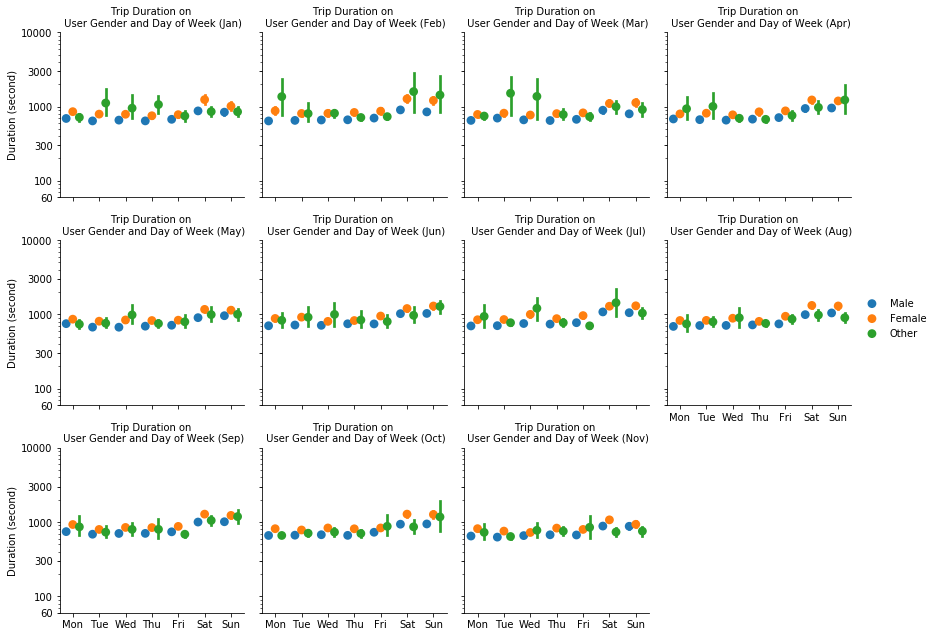

In [10]:
g = sb.FacetGrid(data=trips_clean, col='start_month', col_wrap=4)
g.map(sb.pointplot, 'start_day_of_week', 'duration_sec', 'member_gender', order = ordinal_var_dict['day_of_week'], 
      hue_order=['Male','Female', 'Other'], linestyles='', dodge = 0.5, palette=sb.color_palette())
g.set(yscale='log')
g.set(ylim = np.array([60, 10000]))
# Set tick and labels
g.set_titles('Trip Duration on \n User Gender and Day of Week ({col_name})')
g.set(yticks = dur_log_ticks_lim)
g.set_yticklabels(dur_log_ticks_lim)
g.set_ylabels('Duration (second)')
g.set_xlabels('')
g.add_legend()
plt.show()

## The Duration in terms of User Gender and User Type

If we check the duration by considering the user type and user gender, we can get that the female and other gender groups' trip duration are longer than the male user group for both user types.

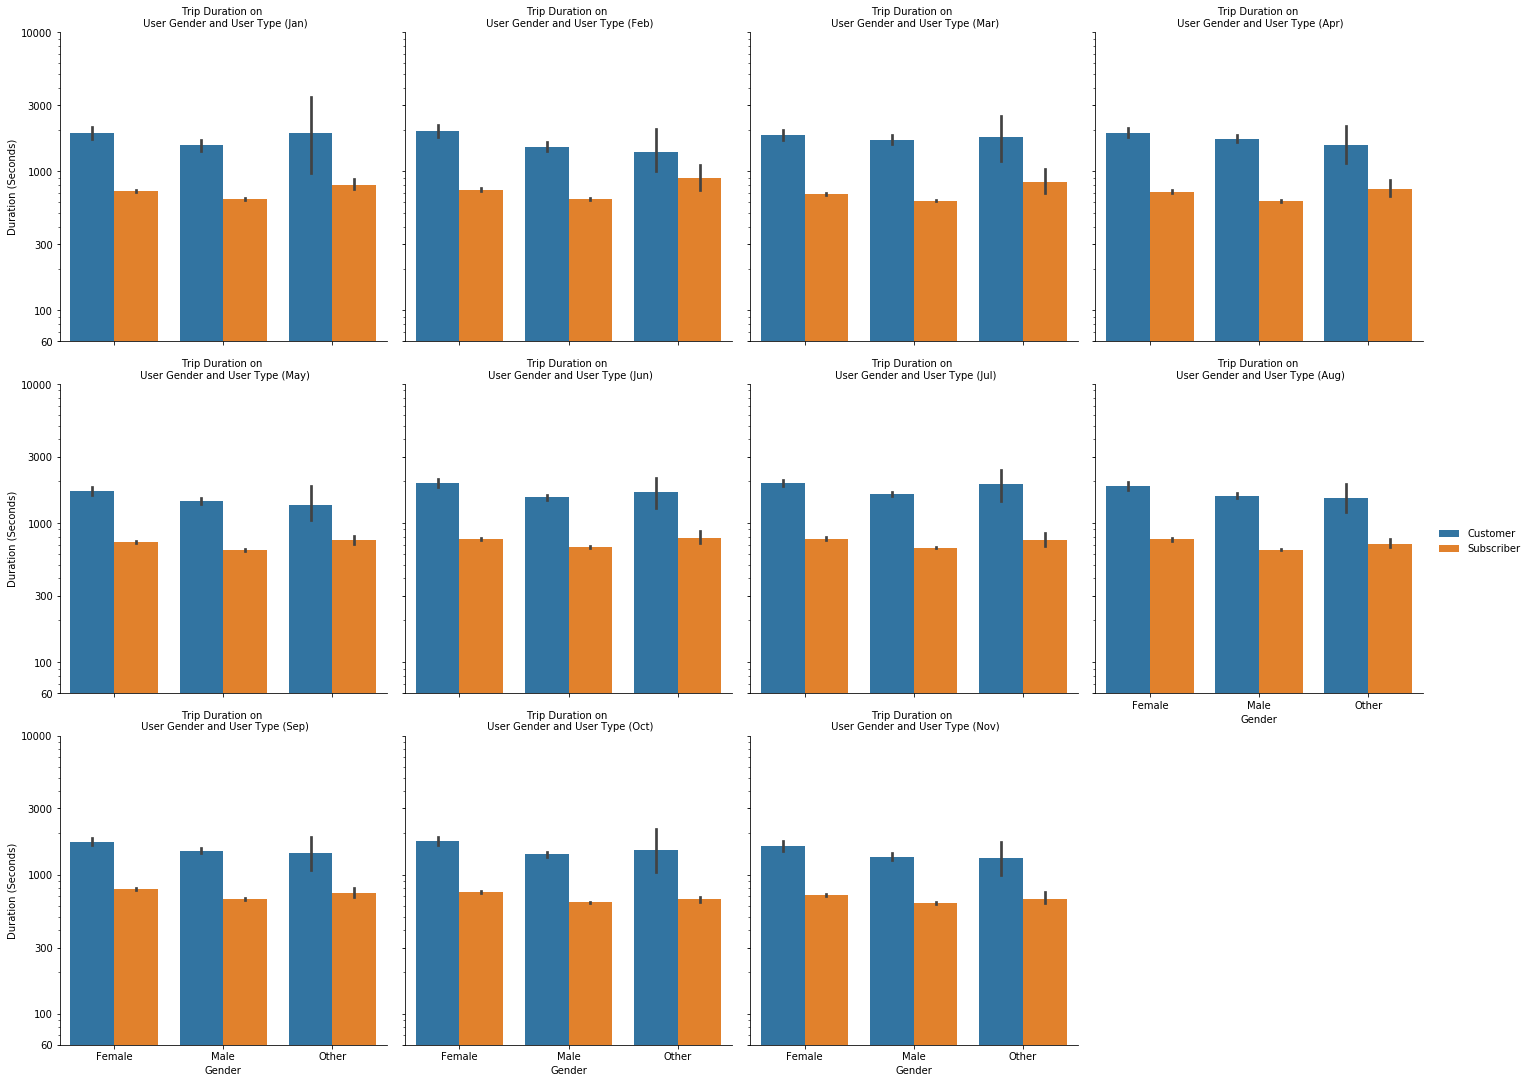

In [11]:
g = sb.catplot(data=trips_clean, x='member_gender',y='duration_sec',col='start_month',hue='user_type', kind='bar', col_wrap=4)
g.set_titles('Trip Duration on \n User Gender and User Type ({col_name})')
g._legend.set_title('')
g.set_xlabels('Gender')
g.set_ylabels('Duration (Seconds)')
g.set(yscale='log')
g.set(ylim = np.array([60, 10000]))
g.set(yticks = dur_log_ticks_lim)
g.set_yticklabels(dur_log_ticks_lim)
plt.show()